## Overview

This analysis is based on the attributes of football players released on [FIFA19](https://www.kaggle.com/karangadiya/fifa19)  dataset on Kaggle. The dataset consists of more than 18000 records of player data with around 90 attributes extracted from FIFA database. In this project, we perform data analysis using **Spark packages**.
 

In this analysis, we divide the task into three parts.

- **Part 1**: Exploratory Data Analysis

- **Part 2**: Clustering Analysis, and identify the position profiles of each cluster

- **Part 3**: Classification Analysis, and evaluate the performance of different algorithms using cross validation;

## Part 1 - Exploratory Data Analysis

### 1.0. Libraries and data files
***

In [1]:
!apt-get update
# importing the necessary spark environment and getting jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-2.4.0-bin-hadoop2.7'

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1

In [ ]:
#only required for jupyter
import os
os.environ['SPARK_HOME'] = 'D:/Projects/spark-2.4.0-bin-hadoop2.7'

In [2]:
# getting the data
!pip install -q wget
!pip install -q findspark
import wget
data_19 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_19_players.csv'
data_21 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_21_players.csv'
dataset_19 = wget.download(data_19)
dataset_21 = wget.download(data_21)

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

### 1.1 Data Exploration
***

In [112]:
# importing the 'FIFA_19.csv' as a Spark dataframe
spark = SparkSession.builder.appName('FIFA_19').config('spark.sql.caseSensitive', 'true').getOrCreate()
# not including header as data while reading so the header value is made true
df_19 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_19_players.csv')
df_19.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate| Body 

In [5]:
df_21 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_21_players.csv')
df_21.show()

+---------+--------------------+-----------------+--------------------+---+-------------------+---------+---------+-----------+-------------------+--------------------+-----------+-------+---------+---------+--------+----------------+--------------+------------------------+---------+-----------+-------------+--------------------+---------+------------------+--------------------+-------------+------------------+-----------+-------------------+--------------------+---------------+--------------------+----+--------+-------+---------+---------+------+---------+-----------+----------+-----------+--------+--------------+--------------------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+--------

Merging the 2019 and 2021 dataframe to get the overall, potential, value in 2021 for every player.

In [86]:
# first renaming the id column in fifa 21 database same as the id column in fifa 19 database for merging later
df_21 = df_21.withColumnRenamed('sofifa_id','ID')
# joining the two dataframes on id and only merging overall, potential and value_eur to the fifa 19 database
df = df_19.join(df_21['ID','overall','potential','value_eur'], on=['ID'], how='left_outer')
df.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill

In [7]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- value(M): string (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)
 |-- Contract 

Getting the summary statistics:

In [8]:
# while taking summary statistics we'll only use players that are present in both FIFA 19 and FIFA 21 databases as we are 
# performing comparison between these two years.
temp_df = df.na.drop(subset=['overall','value_eur'])
temp_df.describe().show()

+-------+-----------------+---------+------------------+--------------------+-----------+--------------------+-----------------+-----------------+--------------------+--------------------+-----------------+------------------+------------------+--------------+------------------------+------------------+------------------+--------------+---------+---------+--------+------------------+-----------+--------------------+--------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------

From the above statistics, it is seen that the average overall in 2019 is 67.86 and in 2021, it has increased to 68.63. On the other hand, the average potential has decreased from 73.05 to 72.14. In two years, the set of  players started to meet their potential while their potential to grow has decreased.

Checking the statistics (min, mean and max) for Age, Overall:

In [9]:
# use aggregate to calculate min, max and mean

# calculating the minimum age
min_age = df.agg({'Age':'min'}).show()

# calculating the maximum age
max_age = df.agg({'Age':'max'}).show()

# calculating the mean age
mean_age = df.agg({'Age':'avg'}).show()

+--------+
|min(Age)|
+--------+
|      16|
+--------+

+--------+
|max(Age)|
+--------+
|      45|
+--------+

+------------------+
|          avg(Age)|
+------------------+
|25.122205745043114|
+------------------+



In [10]:
# calculating the minimum overall
min_overall = df.agg({'Overall':'min'}).show()

# calculating the maximum overall
max_overall = df.agg({'Overall':'max'}).show()

# calculating the mean overall
mean_overall = df.agg({'Overall':'avg'}).show()

+------------+
|min(Overall)|
+------------+
|          46|
+------------+

+------------+
|max(Overall)|
+------------+
|          94|
+------------+

+-----------------+
|     avg(Overall)|
+-----------------+
|66.23869940132916|
+-----------------+



Finding the position having highest average overall:

In [11]:
# grouping the data first by Position, aggregating the Overall and sorting the data to get the position 
# with highest overall 
df_overall_position = df.groupby('Position').agg({'Overall':'AVG'})
df_overall_position.orderBy(df_overall_position['avg(Overall)'].desc()).take(1)
#df_overall_position.sort('avg(Overall)',ascending=False).first()

[Row(Position='LF', avg(Overall)=73.86666666666666)]

Finding the top 3 countries with highest Avg Overall:

In [12]:
# grouping first by Countries and aggregating the Overall and sorting to get the top 3 countries with 
# highest average overall
df_overall_nationality = df.groupby('Nationality').agg({'Overall':'AVG'})
df_overall_nationality.orderBy(df_overall_nationality['avg(Overall)'].desc()).take(3)

[Row(Nationality='United Arab Emirates', avg(Overall)=77.0),
 Row(Nationality='Central African Rep.', avg(Overall)=73.33333333333333),
 Row(Nationality='Israel', avg(Overall)=72.14285714285714)]

Finding the average potentials on country by position:

In [13]:
# creating a pivot table in which the value of column Nationality is transposed to multiple columns 
pivot_df = df.groupBy('Position').pivot('Nationality').avg('Potential')
pivot_df.show(pivot_df.count())

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+--------------------+----+------------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+----

Further, viewing the highest average potential for each position.

In [14]:
# renaming the name of a country to avoid syntax error in the next stage
pivot_df = pivot_df.withColumnRenamed('Central African Rep.', 'Central African Republic')

In [15]:
# removing the null position from the dataframe
pivot_df = pivot_df.filter((pivot_df.Position != 'NA'))
pivot_df.show(pivot_df.count())

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+------------------------+----+-----------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+-

In [16]:
# finding the maximum value for each row from all columns excluding Position
from pyspark.sql.functions import greatest, col, lit, coalesce, sum
#rowmax = sum([coalesce(col(x), lit(0)) for x in pivot_df.columns])
rowmax = greatest(*[coalesce(col(x), lit(0)) for x in pivot_df.columns[1:]]) 
# adding the column containing maximum values
pivot_df.withColumn('Position(Maximum_Potential)',rowmax).show(pivot_df.count())

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+------------------------+----+-----------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+-

Finding the name of countries with highest average potential for each position is better for understanding. So, we discover the countries having players with highest average potential in each position.  

In [17]:
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W

# creating a dataframe with a column whose values contain an array of country name and average potential value
pdf = pivot_df.withColumn('Maximum_Avg_Potential',F.explode( \
        F.array([F.array([F.lit(cols), F.col(cols)]) for cols in pivot_df.columns[1:]])))

# creating a dataframe such that the country name and avg potential values are separated in two columns
pdf = pdf.select('Position', F.col('Maximum_Avg_Potential').getItem(0).alias('Country'), \
                 F.col('Maximum_Avg_Potential').getItem(1).cast(T.IntegerType()).alias('Avg_Potential'))

# creating a rank based on average potential for each position in descending order
pdf = pdf.withColumn('Rank', F.rank().over(W.partitionBy('Position').orderBy(F.col('Avg_Potential').desc())))

# selecting rows with rank equal to 1 and this gives the maximum average potential value 
pdf.where('Rank=1').show(pdf.count())

+--------+--------------------+-------------+----+
|Position|             Country|Avg_Potential|Rank|
+--------+--------------------+-------------+----+
|      RF|           Argentina|           87|   1|
|     LWB|            Portugal|           82|   1|
|     LCM|            Slovakia|           87|   1|
|      LM|               Gabon|           82|   1|
|     RDM|      Czech Republic|           83|   1|
|      LF|             Belgium|           86|   1|
|     CAM|            Slovakia|           80|   1|
|     RAM|             Morocco|           86|   1|
|      LB|             Ukraine|           76|   1|
|      LW|        Burkina Faso|           84|   1|
|     RCM|                Mali|           84|   1|
|      GK|             Nigeria|           82|   1|
|      RB|              Panama|           80|   1|
|      RS|            Cameroon|           81|   1|
|     LCB|              Gambia|           81|   1|
|      CM|Central African R...|           85|   1|
|      RW|              Kosovo|

The most interesting finding from the above dataframe is that Dominican Republic has highest average potential for the striker position. It is well known that unlike European, South American or African continent, players from other continents rarely make it to the big stage. So, it can be assumed that player is an outlier, and is among the few players with highest ratings in that country. Not many scouts might be well aware about that striker. It is good to observe that player's game and see if we can sign that player and make one of the prospects in football.

In [18]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

#df_view = 'soccer_analysis'
df.createOrReplaceTempView('soccer_analysis')

In [19]:
# viewing the players from Dominican Republic
spark.sql("""
          Select * from soccer_analysis where Nationality = 'Dominican Republic'
          """).show()

+------+----------+---+--------------------+------------------+--------------------+-------+---------+-----------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|      Name|Age|               Photo|       Nationality|                Flag|Overall|Potential|       Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|   Work Rate

It is seen that there are only two players from Dominican Republic in the FIFA 2019 database. And, the player with highest potential as a striker is Mariano who is 24 years old. Since, he has already signed for one of the top clubs in Europe, it is hard to lure him away from the club. The release clause of 42.5 millions is moderate considering the current market in 2019. 

Finding the position with highest average potential for Australia: 

In [20]:
# selecting the highest average Potential along with the position for Australia
pivot_df.createOrReplaceTempView('pivot_soccer_analysis')
spark.sql("""
          Select Position, Australia from pivot_soccer_analysis Order By Australia Desc Limit 1
          """).show(30)

+--------+---------+
|Position|Australia|
+--------+---------+
|     RDM|     77.0|
+--------+---------+



In [21]:
# finding the name of the Australian player with highest average potential 
spark.sql("""
          Select * from soccer_analysis Where Nationality = 'Australia' And Position = 'RDM'
          """).show()

+------+---------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|     Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|   Work Rate

Finding the under 20 players with the highest and worst potential

In [22]:
# filtering the dataset based on age (under 20) and then arranging the overall in descending order
spark.sql("""
          Select * from soccer_analysis Where Age < 20 Order By Overall Desc
          """).show()

+------+-------------------+---+--------------------+-------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|               Name|Age|               Photo|  Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak F

Best player under 20 (Kylian Mbappe) and he has the best potential as well 

In [23]:
# under 20 players having worst potential
spark.sql("""
          Select * from soccer_analysis Where Age < 20 Order By Potential Asc
          """).show()

+------+-------------+---+--------------------+-------------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|        Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak F

In [24]:
# finding the Australian player with highest potential
spark.sql("""
          Select * from soccer_analysis Where Nationality = 'Australia' Order By Potential Desc
          """).show()

+------+-------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+--------------------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Ski

In [25]:
# finding the Australian player with lowest potential
spark.sql("""
          Select * from soccer_analysis Where Nationality = 'Australia' Order By Potential Asc
          """).show()

+------+--------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|          Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Move

**Relationship between age of players with their potential and overall**

Finding relationships between age and average potential and age and average overall:

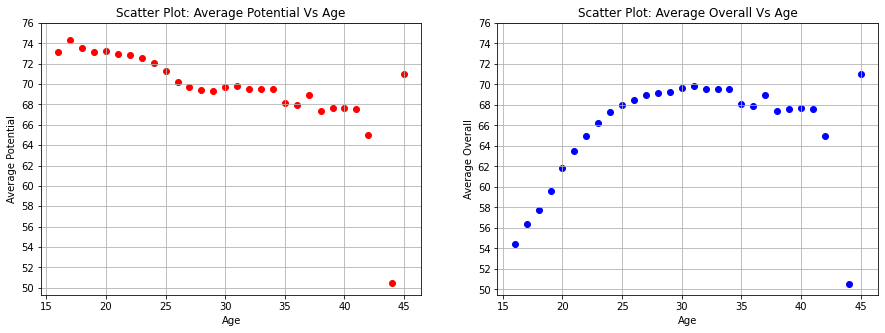

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# creating two dataframes that hold Age with Average Potential and Average Overall along with renaming the aggregated columns
df_age_potential = df.groupby('Age').avg('Potential').withColumnRenamed('avg(Potential)', 'Average Potential')
df_age_overall = df.groupby('Age').avg('Overall').withColumnRenamed('avg(Overall)', 'Average Overall')

# first, converting the above two pyspark dataframes to Pandas and storing in a variable
# then, concatenating those two pandas dataframe setting axis 1 i.e. by column
data = [df_age_potential.select('*').toPandas(),df_age_overall.select('Average Overall').toPandas()]
df_age = pd.concat(data, axis=1)
df_age.head(5)

# plotting 
# creating two subplots for plotting Average Potential and Average Overall against Age
fig, (ax1,ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(15,5))
# using first scatter plot for Average Potential and the second for Average Overall 
ax1.scatter(df_age['Age'], df_age['Average Potential'], color='r')
ax2.scatter(df_age['Age'], df_age['Average Overall'], color='b')
# setting y ticks, labels and titles for both plots
ax1.set_yticks(list(range(50,78,2)))
ax2.set_yticks(list(range(50,78,2)))
ax1.set_xlabel('Age')
ax1.set_ylabel('Average Potential')
ax1.set_title('Scatter Plot: Average Potential Vs Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Average Overall')
ax2.set_title('Scatter Plot: Average Overall Vs Age')
# enabling grid view
ax1.grid(True)
ax2.grid(True)
plt.show()

It is seen from the above scatter plots that average potential decreases with age while average overall increases with age. At age 31, both average potential and average overall meet at the same point (70). So, by the age of 31, players will realise their full potential. After 31, both average potential and average overall declines. However, we can see that at 45 both average potential and overall reached a high point which can be considered as an outlier.

In [27]:
# finding the correlation matrix
df_age.corr(method ='pearson') 

,Age,Average Potential,Average Overall
Age,1.000000,-0.703127,0.370369
Average Potential,-0.703127,1.000000,0.199843
Average Overall,0.370369,0.199843,1.000000


The above correlation matrix reflects the same relationship that can be seen in scatter plots.

Dealing Missing Values:

In this stage, we examine the dataset to see the necessary operations required on data to ease our analysis. Based on the examination, we develop separate transformers that can perform data manipulation to output the data in a desired format.

In [28]:
# checking the missing values
from pyspark.sql.functions import count, col
null_values_count = df.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df.columns])
null_values_count.show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

In this analysis, the attributes that we are concerned with are player attributes that has impacts on players' gameplay such as 'Crossing', ShortPassing', etc. We are only concerned with forwards, midfielders and defenders not goalkeepers. It is seen that all attributes of interests have 48 missing values which include goalkeeping attributes too. So, we need to see if those missing values for different attributes belong to goalkeepers only before performing imputation or deletion of missing values.

In [29]:
# checking the missing values after removing goalkeepers
df_non_goalkeeper = df.filter(df['Position'] != 'GK')
df_non_goalkeeper.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df.columns]).show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

It is seen that no missing values are present in our many attributes of interests for players belonging to positions other than goalkeepers. Important features in our analysis such as value(M), potential and value_eur, still have missing values, so appropriate operations to deal with those missing values should be performed before we proceed to other analysis.

Handling of missing values in Value_2019(M) column:

In [30]:
spark.sql("""
          Select * from soccer_analysis Where value_eur Is NUll
          """).show()

+------+---------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|           Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Mo

It is seen that although we have missing values for players in 2019, we can find the value of some of those players in 2021. Based on the value in 2021, we perform imputation of missing values in value column in 2019. To do that, we first compare the values in both years and calculate the percentage variation in values in those two years. Using that variation, we calculate the figures for missing values. 

In [31]:
spark.sql("""
          Select * from soccer_analysis Where `value(M)` Like '%K'
          """).show()

+------+-------------+---+--------------------+--------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|   Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill 

All the issues seen above have to be dealt before proceeding to further analysis. To deal with those issues, a separate python script has been developed which we will import later on in this analysis to create dataframes that are free from complications seen above.

Creating Pipelines for Data Preprocessing:

In this stage, we create two pipelines for regression and classification tasks. Depending on the tasks, certain operations are omitted in the pipeline. For example, for classification tasks, we will not use ValueImputer function to impute missing values for players monetary values in 2019 and 2021 as classification is made independent of these two columns.

Here, we import two python scripts containing transformers that we developed according to our examination in the previous section. The first python script is data_preprocessor.py which contains classes such as ValueManipulator, UnifyValue and ValueImputer. The second script is target_generator, and it contains classes such as ProfitGenerator and GrowthGenerator.

In [32]:
# only for google colab
!git clone https://github.com/Gooner12/FIFA_2019.git FIFA_2019
!mv "/content/FIFA_2019/data_preprocessor.py" "/content/"
!mv "/content/FIFA_2019/target_generator.py" "/content/"
!mv "/content/FIFA_2019/encoder.py" "/content/"

Cloning into 'FIFA_2019'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 177 (delta 93), reused 119 (delta 61), pack-reused 0
Receiving objects: 100% (177/177), 4.84 MiB | 12.55 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [33]:
from pyspark.ml import Pipeline
import data_preprocessor, target_generator

# defining the stage that changes the units of players' values in 2021 along with renaming columns based on the year 
value_manipulation = data_preprocessor.ValueManipulator()
# defining the stage that standardises the players' values in 2019 to millions
value_standardisation = data_preprocessor.UnifyValue()
# defining the stage that imputes and removes missing values present in players' values in 2019 and 2021
value_imputation = data_preprocessor.ValueImputer()
# defining the stage that generates labels based on profits in two years for regression
regression_target = target_generator.ProfitGenerator()
# defining the stage that generates labels based on the potential to grow in two years
classification_target = target_generator.GrowthGenerator()

DataFrame for Regression:

In [34]:
# creating a pipeline to generate dataframe for regression
pipeline_regression = Pipeline(stages=[value_manipulation, value_standardisation, value_imputation, regression_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model = pipeline_regression.fit(df)
regression_df = pipeline_model.transform(df)

In [35]:
regression_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall_2019: integer (nullable = true)
 |-- Potential_2019: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value_2019(M): double (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)

In [36]:
regression_df.show(5)

+------+-----------------+---+--------------------+-----------+--------------------+------------+--------------+-------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|               Club|           Club Logo|Value_2019(M)|wage(K)|S

DataFrame for Classification

In [37]:
# creating a pipeline to generate dataframe for classification
pipeline_classification = Pipeline(stages=[value_manipulation, value_standardisation, classification_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model2 = pipeline_classification.fit(df)
classification_df = pipeline_model2.transform(df)

In [38]:
classification_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall_2019: integer (nullable = true)
 |-- Potential_2019: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value_2019(M): float (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)


In [39]:
classification_df.show(5)

+------+-----------------+---+--------------------+-----------+--------------------+------------+--------------+-------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|               Club|           Club Logo|Value_2019(M)|wage(K)|Specia

## Part 2 - Unsupervised Learning: Kmeans




### 2.1 Data Preparation
***

In this stage, we perform clustering of players after grouping them in three groups, DEF, MID and FWD, based on their attributes. Later, we analyse what type of positions are mainly included in each cluster. Also, for clustering purpose, we use the original dataframe (2019 data). We save classification_df and regression_df for classification and regression purposes.

In [113]:
# removing the position GK and storing in a new dataframe
df_19 = df_19.filter(df_19['Position'] != 'GK')
# viewing the unique values in the filtered dataframe and check if GK has been removed
df_19.cache()
#df_19.count()

DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall: int, Potential: int, Club: string, Club Logo: string, value(M): string, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, SlidingTackle: in

In [105]:
df_19.select('*').explain()

== Physical Plan ==
InMemoryTableScan [ID#2671271, Name#2671272, Age#2671273, Photo#2671274, Nationality#2671275, Flag#2671276, Overall#2671277, Potential#2671278, Club#2671279, Club Logo#2671280, value(M)#2671281, wage(K)#2671282, Special#2671283, Preferred Foot#2671284, International Reputation#2671285, Weak Foot#2671286, Skill Moves#2671287, Work Rate#2671288, Body Type#2671289, Real Face#2671290, Position#2671291, Jersey Number#2671292, Joined#2671293, Loaned From#2671294, ... 40 more fields]
   +- InMemoryRelation [ID#2671271, Name#2671272, Age#2671273, Photo#2671274, Nationality#2671275, Flag#2671276, Overall#2671277, Potential#2671278, Club#2671279, Club Logo#2671280, value(M)#2671281, wage(K)#2671282, Special#2671283, Preferred Foot#2671284, International Reputation#2671285, Weak Foot#2671286, Skill Moves#2671287, Work Rate#2671288, Body Type#2671289, Real Face#2671290, Position#2671291, Jersey Number#2671292, Joined#2671293, Loaned From#2671294, ... 40 more fields], StorageLev

To make the later stage easier, we define the position group by using the position feature (attributes on Position).
- DEF = [LB,LWB,RB,LCB,RCB,CB,RWB] ,
- FWD = [RF,LF,LW,RS,RW,LS,CF,ST] ,
- MID = [LCM,LM,RDM,CAM,RAM,RCM,CM,CDM,RM,LAM,LDM]

In [114]:
from pyspark.sql.functions import when,col

# creating a list of specific positions
DEF = ['LB','LWB','RB','LCB','RCB','CB','RWB']
FWD = ['RF','LF','LW','RS','RW','LS','CF','ST']  
MID = ['LCM','LM','RDM','CAM','RAM','RCM','CM','CDM','RM','LAM','LDM'] 

# creating a new column which stores values based on conditions
df_kmeans_new = df_19.withColumn('Position_Group',F.when(F.col('Position').isin(DEF),'DEF')\
                                  .when(F.col('Position').isin(FWD),'FWD')\
                                  .when(F.col('Position').isin(MID),'MID').otherwise(0))
# checking if correct group has been assigned for specific playing positions
df_kmeans_new.select('Position','Position_Group').distinct().show(50)

+--------+--------------+
|Position|Position_Group|
+--------+--------------+
|     LCB|           DEF|
|      LS|           FWD|
|     RCB|           DEF|
|      ST|           FWD|
|      CF|           FWD|
|     RAM|           MID|
|     RCM|           MID|
|     LCM|           MID|
|      CM|           MID|
|      LF|           FWD|
|      RW|           FWD|
|      LB|           DEF|
|     CDM|           MID|
|     LDM|           MID|
|     RDM|           MID|
|      LM|           MID|
|     LWB|           DEF|
|      RB|           DEF|
|      LW|           FWD|
|      RS|           FWD|
|     LAM|           MID|
|     RWB|           DEF|
|      RM|           MID|
|      CB|           DEF|
|      RF|           FWD|
|     CAM|           MID|
+--------+--------------+



Now, we create a feature vector from different features of a player. We only take the feature vector for clustering purpose removing the Position_Group and Position to create the feature for Kmeans




In [115]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

features_col = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
# selecting only ID and features, which is the feature vector in a new dataframe
df_kmeans = vec_assembler.transform(df_kmeans_new).select('ID','features')
df_kmeans.show(3)

+------+--------------------+
|    ID|            features|
+------+--------------------+
|158023|[173.736,72.12112...|
| 20801|[188.976,83.00733...|
|190871|[179.832,68.0388,...|
+------+--------------------+
only showing top 3 rows



Now we plot the elbow plot to determine the optimum number of clusters for our dataset. We test with a range of cluster numbers from 2 to 20.

In [116]:
# creating an array to store the within sum of squared errors for different cluster numbers
cost = np.zeros(21)

for k in range(2,21):
    # initialising k means with seed value to enable reproducability and fitting the model to df_kmeans
    kmeans_iter = KMeans().setK(k).setSeed(2020)
    model = kmeans_iter.fit(df_kmeans)
    # storing the within sum of squared errors in the cost array
    cost[k] = model.computeCost(df_kmeans)

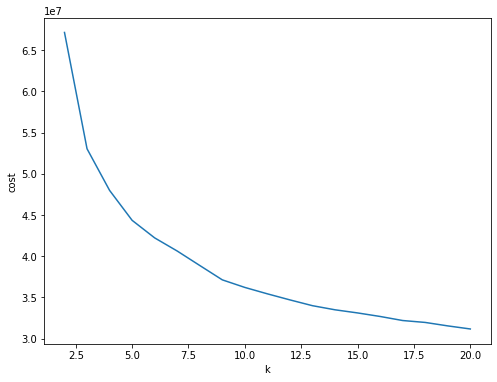

In [117]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.set_xlabel('k')
ax.set_ylabel('cost')

#plotting the within sum of squared errors for each cluster number
ax.plot(range(2,21),cost[2:21])

From the above plot, it can be seen that after k=8 there is not a steep decline in the cost (sum of squared error), so we take k=8 as our elbow point. For clustering, we take 8 as the ideal number of clusters.


### 2.2 K-Means
***



In [118]:
k = 8

kmeans = KMeans().setK(k).setSeed(2020)
model = kmeans.fit(df_kmeans)
# assigning the cluster centers
print('***Cluster Centres***')
cluster_centers = model.clusterCenters()
for i in cluster_centers:
  print(i) # printing the centers

***Cluster Centres***
[177.45568889  77.43733424  55.1521164   69.76785714  66.54365079
  63.61838624  63.81216931  67.9755291   57.9702381   50.59193122
  51.62566138  68.80026455  71.45304233  72.56944444  69.84060847
  66.64484127  64.91005291  71.04034392  71.06547619  68.28835979
  72.6957672   63.88558201  59.07473545  29.97949735  70.10846561
  60.4728836   65.3234127   65.73544974  32.12896825  27.96097884
  24.36904762]
[172.57407959  74.18369877  67.19897959  57.50170068  59.55994898
  72.65008503  56.83418367  69.68707483  66.08886054  61.5454932
  69.27295918  72.10204082  69.22746599  68.61479592  71.1164966
  70.02763605  70.50807823  70.98044218  68.39328231  76.0795068
  68.60416667  65.91411565  70.49532313  67.77380952  64.6420068
  68.03911565  59.26785714  69.40093537  65.37967687  68.28103741
  65.41284014]
[186.0693585   80.24622656  35.22898032  26.64713775  64.65116279
  53.75268336  28.77728086  39.25357782  31.22406082  30.259839
  47.46735242  49.87880143  54

In [119]:
# assigning the unique column to a cluster center while taking off the features column using transform method
predictions = model.transform(df_kmeans).select('ID','prediction')
# assigning the list of predicted ids
predictions_list = predictions.collect()

# # instantiating a sqlContext object
# sqlContext = SQLContext(spark)
# creating a dataframe using SQLContext object
df_prediction = sqlContext.createDataFrame(predictions_list)
df_prediction.show(10)

+------+----------+
|    ID|prediction|
+------+----------+
|158023|         4|
| 20801|         4|
|190871|         4|
|192985|         1|
|183277|         4|
|177003|         1|
|176580|         4|
|155862|         1|
|188545|         4|
|182521|         1|
+------+----------+
only showing top 10 rows



In [120]:
# joining the original dataframe containing Position_Group to the prediction dataframe using common column ID
df_prediction_complete = df_prediction.join(df_kmeans_new,'ID')
df_prediction_complete.show()

+------+----------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+--------------+
|    ID|prediction|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak F

In [121]:
# counting the position group present in each cluster 
df_prediction_complete.groupby('prediction','Position_Group').agg(F.count('ID')).sort('prediction').show(30)

+----------+--------------+---------+
|prediction|Position_Group|count(ID)|
+----------+--------------+---------+
|         0|           MID|      255|
|         0|           DEF|        1|
|         0|           FWD|     1221|
|         1|           MID|     1610|
|         1|           FWD|       51|
|         1|           DEF|      696|
|         2|           DEF|     2167|
|         2|           MID|       70|
|         2|           FWD|        1|
|         3|           FWD|     1142|
|         3|           MID|      108|
|         3|           DEF|        1|
|         4|           DEF|        6|
|         4|           MID|     1158|
|         4|           FWD|      471|
|         5|           MID|     1383|
|         5|           FWD|       24|
|         5|           DEF|     1738|
|         6|           FWD|      493|
|         6|           DEF|       17|
|         6|           MID|     1600|
|         7|           DEF|     1240|
|         7|           FWD|       15|
|         7|

## Part 3 - Supervised Learning: Classification on Position_Group


In this part, we try to predict the position group of the player.

### 3.1 Data Preparation

We remove the feature of position and only use the skill set features and the cluster results from Kmeans as the input. The target for classification is "Position_Group".
***

In [122]:
# renaming the column prediction in our dataframe as Cluster and reflecting the changes in a new dataframe df_kmeans_pred
df_kmeans_pred = df_prediction_complete.withColumnRenamed('prediction', 'Cluster')
df_kmeans_pred.cache()
df_kmeans_pred.show(5)

+------+-------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+--------------+
|    ID|Cluster|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Sk

In [77]:
from pyspark.ml.feature import VectorAssembler
# selecting the attributes to get a feature vector later
features_col = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Cluster']


vec_assembler_ = VectorAssembler(inputCols=features_col, outputCol='features')
# this dataframe contains the feature vector generated from players' attributes and their clusters
df_class = vec_assembler_.transform(df_kmeans_pred).select('features','Position_Group')
df_class.show(3)

+--------------------+--------------+
|            features|Position_Group|
+--------------------+--------------+
|[173.736,72.12112...|           FWD|
|[188.976,83.00733...|           FWD|
|[179.832,68.0388,...|           FWD|
+--------------------+--------------+
only showing top 3 rows



Performing feature scaling. For this, we use standard scaling on the features.

In [78]:
from pyspark.ml.feature import StandardScaler

standardscaler = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
raw_data = standardscaler.fit(df_class).transform(df_class)
raw_data.select('features', 'Scaled_features','Position_Group').show(5)

+--------------------+--------------------+--------------+
|            features|     Scaled_features|Position_Group|
+--------------------+--------------------+--------------+
|[173.736,72.12112...|[12.9261363965246...|           FWD|
|[188.976,83.00733...|[14.0600080102548...|           FWD|
|[179.832,68.0388,...|[13.3796850420166...|           FWD|
|[155.7528,69.8531...|[11.5881678923229...|           MID|
|[176.784,73.93549...|[13.1529107192706...|           FWD|
+--------------------+--------------------+--------------+
only showing top 5 rows



In Spark, we can not use string as Target data type. So, encoding the Position_Group column by using following encoding: 

FWD = 0
DEF = 1
MID = 2

In [79]:
raw_data_encode = raw_data.withColumn('Target',when(col('Position_Group') == 'DEF', 1)
      .when(col('Position_Group')== 'FWD', 0)
      .otherwise(2))
raw_data_encode.show()

+--------------------+--------------+--------------------+------+
|            features|Position_Group|     Scaled_features|Target|
+--------------------+--------------+--------------------+------+
|[173.736,72.12112...|           FWD|[12.9261363965246...|     0|
|[188.976,83.00733...|           FWD|[14.0600080102548...|     0|
|[179.832,68.0388,...|           FWD|[13.3796850420166...|     0|
|[155.7528,69.8531...|           MID|[11.5881678923229...|     2|
|[176.784,73.93549...|           FWD|[13.1529107192706...|     0|
|[176.784,66.22443...|           MID|[13.1529107192706...|     2|
|[182.88,86.18248,...|           FWD|[13.6064593647627...|     0|
|[182.88,82.100152...|           DEF|[13.6064593647627...|     1|
|[182.88,79.832192...|           FWD|[13.6064593647627...|     0|
|[182.88,76.203456...|           MID|[13.6064593647627...|     2|
|[188.976,78.01782...|           DEF|[14.0600080102548...|     1|
|[176.784,67.13161...|           MID|[13.1529107192706...|     2|
|[170.688,

### 3.2 Training Test Evaluation
***

Splitting the data into train/Test, and evaluating the model performance.

In [53]:
train, test = raw_data_encode.randomSplit([0.7, 0.3], seed=2020)

In [54]:
test.show()

+--------------------+--------------+--------------------+------+
|            features|Position_Group|     Scaled_features|Target|
+--------------------+--------------+--------------------+------+
|[155.448,64.86365...|           DEF|[11.5654904600483...|     1|
|[155.448,68.0388,...|           MID|[11.5654904600483...|     2|
|[155.448,73.93549...|           MID|[11.5654904600483...|     2|
|[155.448,74.84268...|           FWD|[11.5654904600483...|     0|
|[155.448,79.83219...|           DEF|[11.5654904600483...|     1|
|[155.7528,64.8636...|           FWD|[11.5881678923229...|     0|
|[155.7528,78.9250...|           MID|[11.5881678923229...|     2|
|[170.688,63.95647...|           MID|[12.6993620737785...|     2|
|[170.688,69.85316...|           MID|[12.6993620737785...|     2|
|[173.736,64.86365...|           FWD|[12.9261363965245...|     0|
|[173.736,68.0388,...|           FWD|[12.9261363965245...|     0|
|[173.736,68.0388,...|           DEF|[12.9261363965245...|     1|
|[176.784,

Next, we compare three baseline models and select the best baseline model for further tuning in the later step.

In [55]:
# using logistic regression for classification
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol='Target', featuresCol='Scaled_features', maxIter=100)
model_lr = lr.fit(train)

predict_train_lr = model_lr.transform(train)
predict_test_lr = model_lr.transform(test)
predict_test_lr.select('Target', 'prediction').show(10)

+------+----------+
|Target|prediction|
+------+----------+
|     1|       1.0|
|     2|       2.0|
|     2|       2.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
|     0|       0.0|
+------+----------+
only showing top 10 rows



In [56]:
# using random forest for classification
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol='Target', featuresCol='Scaled_features', numTrees=20, maxDepth=5,\
                                            impurity='gini', seed=2020)
model_rf = rf.fit(train)
predict_train_rf = model_rf.transform(train)
predict_test_rf = model_rf.transform(test)
predict_test_rf.select('Target', 'prediction').show(10)

+------+----------+
|Target|prediction|
+------+----------+
|     1|       1.0|
|     2|       2.0|
|     2|       1.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
|     0|       0.0|
+------+----------+
only showing top 10 rows



In [57]:
# using decision tree for classification
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol='Target', featuresCol='Scaled_features', maxDepth=5, maxBins=32, impurity='gini', seed=2020)
model_dt = dt.fit(train)
predict_train_dt = model_dt.transform(train)
predict_test_dt = model_dt.transform(test)
predict_test_dt.select('Target', 'prediction').show(10)

+------+----------+
|Target|prediction|
+------+----------+
|     1|       1.0|
|     2|       2.0|
|     2|       1.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
|     0|       2.0|
+------+----------+
only showing top 10 rows



Evaluating the model using confusion matrix.

In [58]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

def calculate_confusion_matrix(df):
  # the label need to be in float datatype otherwise it won't work
  # creating a column that represents the target but the datatype is float
  df_float = df.select(['prediction','Target']).withColumn('label', F.col('Target').cast(FloatType()))

  # selecting only prediction and label columns
  df_float = df_float.select(['prediction','label'])
  # casting to rdd and mapping to a tuple
  metrics = MulticlassMetrics(df_float.rdd.map(tuple))
  confusion_matrix = metrics.confusionMatrix().toArray()
  # changing the confusion matrix array datatype to int as it's datatype is float
  confusion_matrix = confusion_matrix.astype('int32')
  
  return confusion_matrix, metrics

In [59]:
def calculate_performance_metrics_position(metrics):
  fwd_details = ()
  def_details = ()
  mid_details = ()
 
  # calculating precision, recall and f1-score for different labels
  for lab in 0.0,1.0,2.0:
    if lab == 0:
      precision_fwd = round(metrics.precision(lab) * 100, 2)
      recall_fwd = round(metrics.recall(lab) * 100, 2)
      f1_score_fwd = round(metrics.fMeasure(lab, beta=1.0) * 100, 2)
      fwd_details = fwd_details + (precision_fwd, recall_fwd, f1_score_fwd)

    elif lab == 1:
      precision_def = round(metrics.precision(lab) * 100, 2)
      recall_def = round(metrics.recall(lab) * 100, 2)
      f1_score_def = round(metrics.fMeasure(lab, beta=1.0) * 100, 2)
      def_details = def_details + (precision_def, recall_def, f1_score_def)

    elif lab == 2:
      precision_mid = round(metrics.precision(lab) * 100, 2)
      recall_mid = round(metrics.recall(lab) * 100, 2)
      f1_score_mid = round(metrics.fMeasure(lab, beta=1.0) * 100, 2)
      mid_details = mid_details + (precision_mid, recall_mid, f1_score_mid)

  return fwd_details, def_details, mid_details

Creating tables or dataframes to compare the performance of different classifiers.

In [60]:
# defining a function that generates comparison tables
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

def comparison_table(pos, classifiers, *args):
  # creating a new dataframe from list of classifiers
  #classifiers = ('Random Forest', 'Logistic Regression', 'Decision Tree')
  metrics_detail_list = []
  df_classifier = spark.createDataFrame([(l,) for l in classifiers], ['Classifier'])

  # stating conditions to select data based on player positions
  if pos == 'FWD':
    index = 0
    print('Forwards:')
  elif pos == 'DEF':
    index = 1
    print('Defenders:')
  elif pos == 'MID':
    index = 2
    print('Midfielders:')

  # populating the data for dataframes containing performance indicators
  for i in args:
    metrics_detail_list += [i[index]]
  
  # defining the schema of the dataframes containing performance metrics
  schema = StructType([
      StructField('Precision', FloatType(), False),
      StructField('Recall', FloatType(), False),
      StructField('F1-score', FloatType(), False)
      ])
  
  # creating a dataframe for performance metrics
  pos_df = spark.createDataFrame(metrics_detail_list, schema)

  # adding index to the dataframes to join later
  pos_df = pos_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
  df_classifier = df_classifier.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
  comparison_df = df_classifier.join(pos_df, pos_df.row_index == df_classifier.row_index).drop('row_index')
  
  return comparison_df

In [61]:
# obtaining confusion matrix for three classifiers
confusion_matrix_lr, metrics_lr = calculate_confusion_matrix(predict_test_lr)
performance_lr = calculate_performance_metrics_position(metrics_lr)
confusion_matrix_rf, metrics_rf = calculate_confusion_matrix(predict_test_rf)
performance_rf = calculate_performance_metrics_position(metrics_rf)
confusion_matrix_dt, metrics_dt = calculate_confusion_matrix(predict_test_dt)
performance_dt = calculate_performance_metrics_position(metrics_dt)

In [62]:
# showing the comparison table
classifiers = ('Random Forest', 'Logistic Regression', 'Decision Tree')
comparison_table('FWD', classifiers, performance_rf, performance_lr, performance_dt).show()
comparison_table('DEF', classifiers, performance_rf, performance_lr, performance_dt).show()
comparison_table('MID', classifiers, performance_rf, performance_lr, performance_dt).show()                

Forwards:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|    85.68|  71.0|   77.65|
|Logistic Regression|    82.66| 79.67|   81.14|
|      Decision Tree|    81.65| 71.62|   76.31|
+-------------------+---------+------+--------+

Defenders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|    87.39| 88.08|   87.73|
|Logistic Regression|    90.48| 92.13|    91.3|
|      Decision Tree|    83.08|  88.2|   85.56|
+-------------------+---------+------+--------+

Midfielders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|    78.18| 83.89|   80.94|
|Logistic Regression|    84.21| 84.33|   84.27|
|      Decision Tree|     78.1| 78.51|    78.3|
+---

Write the result...

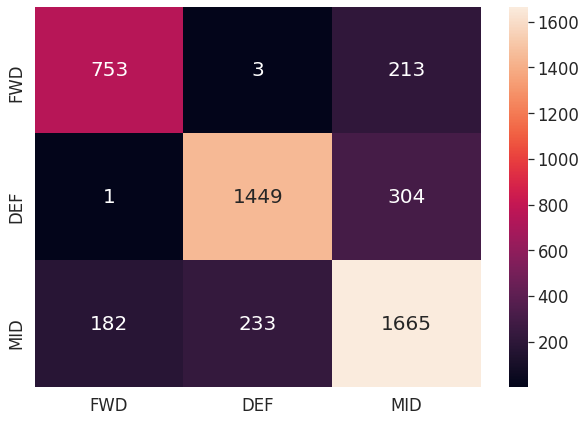

In [ ]:
# creating a heatmap from the confusion matrix
import seaborn as sn 
labels = ['FWD', 'DEF', 'MID'] # specifying the labels in our data based on encoding
#creating a dataframe from the confusion matrix
confusion_df = pd.DataFrame(confusion_matrix, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # setting the label size
# drawing the heat map along with displaying values in a digit format and setting the digit size
sn.heatmap(confusion_df, annot=True, fmt='d', annot_kws={'size': 20})


### 3.3 K-fold Cross-Validation
***

In this section, we perform hyper-parameter tuning to find the best hyper-parameter set using K-fold cross validation along with param grid. 

Preprocessing Stages:

In [123]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import encoder

# creating the preprocessing stages for the Machine Learning pipeline and setting the pipeline
# defining the stage 1
vec_assembler_mlp = VectorAssembler(inputCols=features_col, outputCol="features")
# defining the stage 2
standard_scaler_mlp = StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
# defining the stage 3
encoding_mlp = encoder.LabelEncoder()
# defining the last stage (logistic regression)
logistic_regression = LogisticRegression(featuresCol='Scaled_features', labelCol='Target', maxIter=100, regParam=0, threshold=0.5)

# setting the pipeline for logistic_regression
pipeline_logistic_regression = Pipeline(stages=[vec_assembler_mlp, standard_scaler_mlp, encoding_mlp, logistic_regression])

# building a grid of parameters for logistic regression to be used by the cross-validation
# providing iteration number, different lambda values and threshold values for paramter grids
paramGrid_logistic_regression = ParamGridBuilder().addGrid(logistic_regression.maxIter, [50, 100, 200, 250, 300])\
.addGrid(logistic_regression.regParam, [0.001, 0.01, 0.1, 0, 1, 10]).build()

Splitting the dataset:

In [124]:
# splitting the data into training and testing dataset
training, testing = df_kmeans_pred.randomSplit([0.7, 0.3], seed=2020)

Cross Validation:

In [125]:
# cross validating for logistic regression
crossval_logistic_regression = CrossValidator(estimator=pipeline_logistic_regression,\
                          estimatorParamMaps=paramGrid_logistic_regression,\
                          evaluator=MulticlassClassificationEvaluator(labelCol='Target', predictionCol='prediction'),\
                          numFolds=10)

# fitting the training dataset
cv_logistic_regression = crossval_logistic_regression.fit(training)

In [126]:
# printing the parameter values for the best estimator
print(cv_logistic_regression.getEstimatorParamMaps()[np.argmax(cv_logistic_regression.avgMetrics)])

{Param(parent='LogisticRegression_476ec74d88e9', name='maxIter', doc='max number of iterations (>= 0).'): 300, Param(parent='LogisticRegression_476ec74d88e9', name='regParam', doc='regularization parameter (>= 0).'): 0.0}


In [127]:
# fitting the training data using the best model
prediction_logistic_regression = cv_logistic_regression.bestModel.transform(testing).select('Target', 'prediction')
prediction_logistic_regression.show()

+------+----------+
|Target|prediction|
+------+----------+
|     0|       2.0|
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       1.0|
|     0|       0.0|
|     2|       2.0|
|     1|       1.0|
|     0|       0.0|
|     0|       2.0|
|     1|       2.0|
|     2|       2.0|
|     0|       0.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     2|       2.0|
+------+----------+
only showing top 20 rows



write about what is seen above